# Signature kernel (version rapide)


In [1]:
#import ksig_cpu as ksig
import ksig #Nécessite GPU NVIDIA avec au moins 5 Go de GRAM disponibles

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
def lead_lag(x):
    d = x.shape[0]
    x = x[...,np.newaxis]
    x = np.stack([x]*(2*d), axis = 2).reshape(d, -1)
    x = np.concatenate((x,x), axis = 0)
    for i in range(2*d):
        x[2*d - i - 1] = np.roll(x[2*d - i - 1], -i)
    return x[:, :-(2*d - 1)]


In [4]:
ds = pd.read_csv("pendigits.csv").to_numpy()

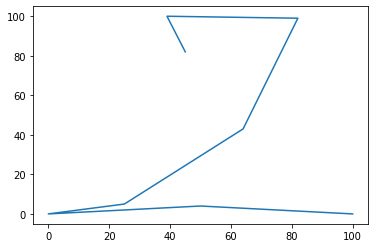

In [5]:
idx = np.random.randint(500)
x_sample = ds[idx][:16].reshape(8,2)[:,0]
y_sample = ds[idx][:16].reshape(8,2)[:,1]
plt.plot(x_sample,y_sample)


In [142]:
X = ds[:, :16].reshape(-1, 8, 2)
n = 3000
scaler_x = StandardScaler()
scaler_y = StandardScaler()

scaler_x.fit(X[:n,:,0])
scaler_y.fit(X[:n,:,1])

X[:,:,0] = scaler_x.transform(X[:,:,0])
X[:,:,1] = scaler_y.transform(X[:,:,1])


y = ds[:, 16]

X_ll = np.array([lead_lag(i.T).T for i in X])
X_train, y_train, X_test, y_test = X[:n], y[:n], X[n:], y[n:]
X_ll_train, y_ll_train, X_ll_test, y_ll_test = X_ll[:n], y[:n], X_ll[n:], y[n:]



### Matrices de Gram
Hyperparamètres dépendants du matériel

n_levels : rang tensoriel maximal considéré 

n_order : ordre d'approximation

n_components : rang dans l'approximation Nystroem et dans la projection aléatoire

\*_ll_\* : HP pour les données lead-lad

In [150]:
n_levels = 3
n_order = 3
n_components = 50

n_ll_levels = 3
n_ll_order = 1
n_ll_components = 20

In [151]:
static_kernel = ksig.static.kernels.RBFKernel()
proj = ksig.projections.CountSketchRandomProjection(n_components=n_components)
static_feat = ksig.static.features.NystroemFeatures(static_kernel, n_components=n_components)

lr_sig_kernel = ksig.kernels.LowRankSignatureKernel(order=n_order, n_levels=n_levels, static_features=static_feat)
lr_sig_kernel.fit(X_train)


LowRankSignatureKernel(n_levels=3, order=3,
                       static_features=NystroemFeatures(n_components=50,
                                                        static_kernel=RBFKernel()))

In [152]:
X_train.shape

(3000, 8, 2)

In [153]:
"""static_kernel_ll = ksig.static.kernels.RBFKernel(sigma = 1., lengthscale = 1.)
proj_ll = ksig.projections.CountSketchRandomProjection(n_components=n_components)
static_feat_ll = ksig.static.features.NystroemFeatures(static_kernel_ll, n_components=n_ll_components)

lr_sig_kernel_ll = ksig.kernels.LowRankSignatureKernel(order=n_ll_order, n_levels=n_ll_levels, static_features=static_feat_ll, sigma=10)
lr_sig_kernel_ll.fit(X_ll_train)"""


'static_kernel_ll = ksig.static.kernels.RBFKernel(sigma = 1., lengthscale = 1.)\nproj_ll = ksig.projections.CountSketchRandomProjection(n_components=n_components)\nstatic_feat_ll = ksig.static.features.NystroemFeatures(static_kernel_ll, n_components=n_ll_components)\n\nlr_sig_kernel_ll = ksig.kernels.LowRankSignatureKernel(order=n_ll_order, n_levels=n_ll_levels, static_features=static_feat_ll, sigma=10)\nlr_sig_kernel_ll.fit(X_ll_train)'

In [154]:
K_XX = lr_sig_kernel(X_train)

In [155]:
#K_ll_XX = lr_sig_kernel_ll(X_ll_train)

In [156]:
clf = SVC(C=1., kernel='precomputed')
clf.fit(K_XX, y_train)
kernel_test = lr_sig_kernel(X_test, X_train)
y_pred = clf.predict(kernel_test)
acc = ( ((y_pred == y_test).sum()/len(y_pred)) )
acc

OutOfMemoryError: Out of memory allocating 1,787,075,584 bytes (allocated so far: 2,593,206,784 bytes).

In [ ]:
clf = SVC(C=10., kernel='precomputed')
clf.fit(K_ll_XX, y_train)
kernel_test = lr_sig_kernel_ll(X_ll_test, X_ll_train)
y_pred = clf.predict(kernel_test)
acc = ( ((y_pred == y_test).sum()/len(y_pred)) )
acc

# Gridsearch

In [ ]:
C = [0.01, 0.1, 1., 10., 100.]
sigma = [0.01, 0.1, 1., 10., 100.]
lengthscale = [0.01, 0.1, 1., 10., 100.]

accuracies = np.zeros((len(sigma), len(lengthscale), len(C)))

for s in range(3, len(sigma)):
    for l in range(len(lengthscale)):
        start_time = time.time()

        static_kernel = ksig.static.kernels.RBFKernel(sigma = sigma[s], lengthscale = lengthscale[l])
        proj = ksig.projections.CountSketchRandomProjection(n_components=n_components)
        static_feat = ksig.static.features.NystroemFeatures(static_kernel, n_components=n_components)

        lr_sig_kernel = ksig.kernels.LowRankSignatureKernel(order=n_order, n_levels=n_levels, static_features=static_feat, sigma=1.)
        lr_sig_kernel.fit(X_train)
        K_XX = lr_sig_kernel(X_train)
        print("K_XX took : ")
        print(time.time() - start_time)
        for c in range(len(C)):
            start_time = time.time()
            clf = SVC(C=C[c], kernel='precomputed')
            clf.fit(K_XX, y_train)
            kernel_test = lr_sig_kernel(X_test, X_train)
            y_pred = clf.predict(kernel_test)
            acc = ( ((y_pred == y_test).sum()/len(y_pred)) )
            accuracies[s][l][c] = acc
            print("K_XX took : ")
            print(time.time() - start_time)
            print(" acc : ")
            print(acc)

In [ ]:
accuracies

In [ ]:
accuracies[3]